In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle as pkl
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from notebook_utils import *
from parameter_estimation import load_data_util
import numpy as np
import pandas as pd
import snap
import operator
from sklearn import metrics
import networkx as nx
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size='13') # controls default text sizes
plt.rc('xtick', labelsize='12')
plt.rc('ytick', labelsize='12')
plt.rc('legend', fontsize='13') # legend fontsize
plt.rc('axes', labelsize='12', titlesize='13')  # fontsize of the x and y labels # fontsize of the axes title
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# infl users (with user ids)
fake_component = 0

# engagement counts (read cascades)
data_dir = '../data/kwon/'
cascades_file = data_dir + 'cascades.txt'
labels_file = data_dir + 'labels.txt'
train_cascades = read_cascades_file(cascades_file)
train_labels = np.loadtxt(labels_file)
print('num cascades', len(train_cascades), len(train_labels))
u_t, u_f, sorted_u = eng_count(train_cascades, train_labels)
top_users = sorted_u[:, 0]

# user index
# idx2u_path = 'models/kwon/last_learned.graphuserdf'
idx2u_path = '../output/all_kwon/kwon/idx2u.txt'
idx2u = np.loadtxt(idx2u_path)  # np.array(pd.read_csv(idx2u_path)['all_users'])
u2idx = dict(zip(idx2u, np.arange(len(idx2u))))
print('num users:', len(idx2u))
# edges learned
# graph_path = models/kwon/last_learned.graphdf'
graph_path = '../output/all_kwon/kwon/learned_graph.tsv'
edf = pd.read_csv(graph_path, header=0, sep='\t')  #sep=',')
print('num edges', len(edf))
edf.head()

num cascades 111 111
t/f 51 60
u_t, u_f, tot 76041 47869 123910
users large eng > 5 2457
users large eng > 10 871
num users: 2930
num edges 377


,u,v,act_0,act_1
0,2125,1706,0.000365,9.979777e-01
1,2125,1719,1.000000,1.000000e+00
2,1230,1719,0.376622,1.081988e-03
3,541,1008,1.000000,8.850981e-14
4,2521,94,0.333355,3.333894e-01


In [3]:
def create_graph_from_df(df):
    """
    df: u, v, act0, act1
    return snap graph PNEANet
    """
    print("creating graph")
    graph = snap.PNEANet.New()
    uidx = {}
    u = list(df['u'])
    v = list(df['v'])
    users = u + v
    i = 0
    for user in users:
        if user not in uidx:
            uidx[user] = i
            i += 1
    for i in range(len(uidx)):
        graph.AddNode(i)
    for index, row in df.iterrows():
        u, v, act0, act1 = row['u'], row['v'], row['act_0'], row['act_1']
        graph.AddEdge(uidx[u], uidx[v])
        EId = graph.GetEId(uidx[u], uidx[v])
        graph.AddFltAttrDatE(EId, act0, 'act_prob_0')
        graph.AddFltAttrDatE(EId, act1, 'act_prob_1')
    print("returing graph")
    return graph, uidx

In [8]:
def filter_edges_by_users(edf, top_users):
    x = edf[(edf['u'].isin(top_users)) & (edf['v'].isin(top_users))]
    users_retained = set(x['u'])  #(set(x['v']))
    users_retained.update(x['v'])
    return x, users_retained

sdf, _ = filter_edges_by_users(edf, top_users)

base_graph, _ = create_graph_from_df(edf)  # create snap graph with different edge attr


creating graph
returing graph


In [9]:
def get_split_graphs(base_graph, comp):
    attr_graph = snap.PNEANet.New()
    num_nodes = base_graph.GetNodes()
    for i in range(num_nodes):
        attr_graph.AddNode(i)
    for EI in base_graph.Edges():
        attr_value = base_graph.GetFltAttrDatE(EI, 'act_prob_{}'.format(comp))
        if attr_value > 0:
            attr_graph.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
            attr_graph.AddFltAttrDatE(EI, attr_value, 'act_prob_{}'.format(comp))
    return attr_graph

true_graph, fake_graph = get_split_graphs(base_graph, 1), get_split_graphs(base_graph, 0) 

In [13]:

def print_graph_props(G):
    print('Edges', G.GetEdges())
    print('Diameter', snap.GetAnfEffDiam(G))  # longest shortest path
    # print('Is weakly connected', snap.IsConnected(G))  # longest shortest path
    GraphClustCoeff = snap.GetClustCf(G, -1)
    print("Clustering coefficient: %f" % GraphClustCoeff)
    NumTriads = snap.GetTriads(G, -1)
    print('Number of triads: %d' % NumTriads)
    Nodes = snap.TIntV()
    for nodeId in range(G.GetNodes()):
        Nodes.Add(nodeId)
    print('Modularity:', snap.GetModularity(G, Nodes))

    print()
    ComponentDist = snap.TIntPrV()
    snap.GetSccSzCnt(G, ComponentDist)
    for comp in ComponentDist:
        print("Size: %d - Number of Components: %d" % (comp.GetVal1(), comp.GetVal2()))
#     ComponentDist = snap.TIntPrV()
#     snap.GetWccSzCnt(G, ComponentDist)
#     for comp in ComponentDist:
#         print("Size: %d - Number of Components: %d" % (comp.GetVal1(), comp.GetVal2()))
    print()
#     CmtyV = snap.TCnComV()
#     modularity = snap.CommunityGirvanNewman(snap.ConvertGraph(snap.PUNGraph, G), CmtyV)
#     for Cmty in CmtyV:
#         print("Community: ")
#         for NI in Cmty:
#             print(NI)
#     print("The modularity of the network is %f" % modularity)
    print()
    
# snap.PrintInfo(base_graph, 'Graph', 'Graph.txt')
for G, name in zip([base_graph, true_graph, fake_graph], ['base', 'true', 'fake']):
    if name == 'base_graph': continue
    else:
        print("-----Graph = {}-------".format(name))
        print_graph_props(G)

-----Graph = base-------
Edges 377
Diameter 1.9483245018305626
Clustering coefficient: 0.072819
Number of triads: 35
Modularity: 0.25

Size: 1 - Number of Components: 529
Size: 2 - Number of Components: 1


-----Graph = true-------
Edges 310
Diameter 1.7274794215447393
Clustering coefficient: 0.053923
Number of triads: 28
Modularity: 0.25

Size: 1 - Number of Components: 529
Size: 2 - Number of Components: 1


-----Graph = fake-------
Edges 301
Diameter 1.6518582236857058
Clustering coefficient: 0.074388
Number of triads: 34
Modularity: 0.25

Size: 1 - Number of Components: 529
Size: 2 - Number of Components: 1




In [14]:
snap.DrawGViz(true_graph, snap.gvlDot, "true_graph.png", "graph t")
snap.DrawGViz(fake_graph, snap.gvlDot, "fake_graph.png", "graph f")

# Heatmaps of edge weights for some users

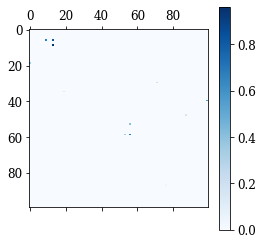

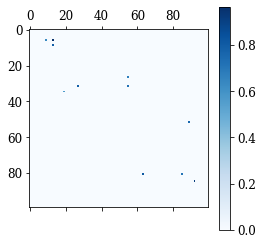

In [57]:

def filter_edges_by_users(edf, top_users):
    x = edf[(edf['u'].isin(top_users)) & (edf['v'].isin(top_users))]
    users_retained = set(x['u'])  #(set(x['v']))
    users_retained.update(x['v'])
    return x, users_retained


def show_mat(sdf, rc_order, attr):
#     sdf = edf[:10]
#     df = pd.crosstab(sdf.u, sdf.v)
#     idx = df.columns.union(df.index)
#     df = df.reindex(index = idx, columns=idx, fill_value=0)
#     G=nx.from_pandas_edgelist(sdf, 'u', 'v')  # nx.from_pandas_dataframe(sdf,'u','v','act_0')
#     adj0 = nx.adjacency_matrix(G)
#     print(adj0.todense())
    
    G = nx.from_pandas_edgelist(sdf,'u','v', edge_attr=[attr], create_using=nx.DiGraph)  # print(G[10642984][28642851]['act1'])
    m = nx.attr_matrix(G, edge_attr=attr, rc_order=rc_order)
    adj_attr = np.array(m)
    return adj_attr

def filter_edges_by_weight(edf, attr, cut):
    x = edf.sort_values(by=attr, ascending=False)[0:cut]
    print(len(x))
    users_retained = set(x['u'])  #(set(x['v']))
    users_retained.update(x['v'])
    return x, users_retained

sdf, _ = filter_edges_by_users(edf, top_users)
users_retained = top_users
# sdf1, ur1 = filter_edges_by_weight(edf, 'act1', 20)  # true  act is high
# sdf0, ur2 = filter_edges_by_weight(edf, 'act0', 20)  # fake  act is high
# sdf = pd.concat([sdf1, sdf0])
# users_retained = list(ur1) + list(ur2)

# print(sdf)
adj0 = show_mat(sdf, users_retained, attr = 'act0')
adj1 = show_mat(sdf, users_retained, attr = 'act1')
# print(sdf.tail())


plt.matshow(adj0, cmap=plt.cm.Blues, label='fake_comp')
plt.colorbar()
plt.matshow(adj1, cmap=plt.cm.Blues, label='true_comp')
plt.colorbar()

print()

20
20



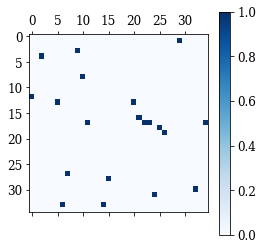

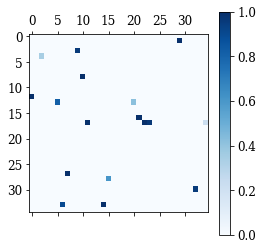

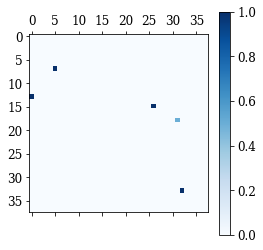

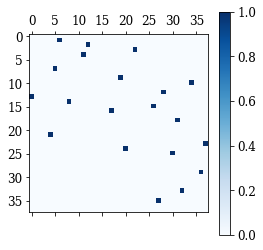

In [63]:
sdf, users_retained = filter_edges_by_weight(edf, 'act0', 20)  # fake act is high
# print(sdf)
adj0 = show_mat(sdf, users_retained, attr = 'act0')
adj1 = show_mat(sdf, users_retained, attr = 'act1')
# print(sdf.tail())


plt.matshow(adj0, cmap=plt.cm.Blues, label='fake_comp')
plt.colorbar()
plt.matshow(adj1, cmap=plt.cm.Blues, label='true_comp')
plt.colorbar()

sdf, users_retained = filter_edges_by_weight(edf, 'act1', 20)  # true act is high
# print(sdf)
adj0 = show_mat(sdf, users_retained, attr = 'act0')
adj1 = show_mat(sdf, users_retained, attr = 'act1')
# print(sdf.tail())


plt.matshow(adj0, cmap=plt.cm.Blues, label='fake_comp')
plt.colorbar()
plt.matshow(adj1, cmap=plt.cm.Blues, label='true_comp')
plt.colorbar()

print()